# Data Literacy
#### University of Tübingen, Winter Term 2021/22
## Exercise Sheet 4
&copy; 2021 Prof. Dr. Philipp Hennig & Nico Krämer & Emilia Magnani

This sheet is **due on Monday, November 22, 2021 at 10am sharp (i.e. before the start of the lecture).**

---

## Data estimation
Last week, we looked at maximum likelihood estimation for exit polls / election data in the context of the German general election in September 2021.
This week, we will continue the analysis and augment the maximum likelihood estimators from last week with uncertainty quantification.



In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats

# For the docstrings / type hints of the functions we provide.
from typing import Union, Optional, Tuple

The next snippet loads the data and extracts the results for one party, the true voting share of that party, and some other useful quantities.

In [2]:
# Load the data
data = pd.read_csv("data_slim.csv")


# Choose one party here.
my_party = "SPD"

# Grouped results
result_my_party = int(data[data["Gruppenname"] == my_party]["Anzahl"].sum())
result_others = int(data[data["Gruppenname"] != my_party]["Anzahl"].sum())

# True proportion of votes that `my_party` received
truth = result_my_party / (result_my_party + result_others)


# All votes as an array of strings
votes_all = np.concatenate(
    (np.tile(my_party, result_my_party), np.tile("Not " + my_party, result_others))
)

# An array of the relevant parties
parties_all = np.array([my_party, "Not " + my_party])

In [3]:
votes_all

array(['SPD', 'SPD', 'SPD', ..., 'Not SPD', 'Not SPD', 'Not SPD'],
      dtype='<U7')

The next snippet provides a function that simulates an exit poll. You can use your solution from last week's sheet instead.

In [4]:
def exit_poll(
    rng: np.random.Generator,
    *,
    poll_size: int,
    votes: np.ndarray,
    parties: np.ndarray,
) -> Tuple[np.ndarray, np.ndarray]:
    """Conduct an exit poll.

    Parameters
    ----------
    rng
        Random number generator.
    poll_size
        Poll size. How many people are polled.
    votes
        The true election results.
    parties
        List of parties.

    Returns
    -------
    Exit poll counts and full exit poll.
    """
    poll = rng.choice(votes, size=(poll_size,), replace=False)
    poll_counts = count(poll=poll[None, :], parties=parties)
    return poll_counts[0], poll


def count(poll: np.ndarray, parties: np.ndarray) -> np.ndarray:
    """Count the number of occurences of a party in an exit poll."""
    return np.count_nonzero(poll[..., None] == parties[None, None, :], axis=1)

rng = np.random.default_rng()
# Some test that checks that the function works
exit_poll_counts, _ = exit_poll(
    rng, poll_size=1000, votes=votes_all, parties=parties_all
)

In [5]:
exit_poll_counts[0]

252

## Uncertainty quantification via Fisher information 

In an exit poll for an election with $K$ parties, the counts $N_k$ for the $k$th party follows a multinomial distribution, 
$$
p(N_1, ..., N_K \mid \pi_1, .., \pi_K) = \frac{\Gamma\left(\sum_k N_k + 1 \right)}{\prod_k \Gamma(N_k + 1)} \prod_{k=1}^K \pi_k^{N_k},
$$
where $\Gamma$ is the Gamma function.
Let $|N| = \sum_k N_k$. Given a sample $(N_1, ..., N_K)$ (an exit poll), the maximum likelihood estimate for $\pi = (\pi_1, ..., \pi_K)$ is
$$
\hat \pi = (N_1 / |N|, ..., N_K / |N|).
$$
In the following, we will consider the case of $K=2$ (the counts for one party, and the counts for "not" this party, i.e., all the others).
This reduces the multinomial distribution to a binomial distribution, with parameters $(\pi, 1 - \pi)$.
You know from the lecture that the Fisher information for this setup is
$$
I(\pi) = \frac{|N|}{\pi (\pi - 1)}.
$$
Asymptotically, the error of the MLE is Gaussian,
$ \hat{\pi} \sim \mathcal{N}\left(\hat{\pi};\pi_\text{truth},  - I(\hat \pi)^{-1}\right)$.

**Task:**
Use the formula for the Fisher information to write a function that computes the (asymptotic) covariance of the MLE. 

In [6]:
def compute_params(exit_poll_counts):

    N = exit_poll_counts.sum()
    pi_hat = exit_poll_counts[0] / N 

    I_pi_hat = N / (pi_hat * (pi_hat-1))
    cov = -(1/I_pi_hat)

    return pi_hat, cov  

In [7]:
compute_params(exit_poll_counts)

(0.252, 0.000188496)

**Task:**
Conduct an (artificial) exit poll, and evaluate how the covariance evolves for increasing exit poll sizes $|N|$.
To this end, plot $f(x) = \mathcal{N}(x; \hat \pi, -I(\hat \pi)^{-1})$ and the true likelihood function $p(N \mid \pi)$ for $|N| \in \{10, 20, 50 \}$, and compare them to the true vote distribution $\pi_\text{truth}$.


In [61]:
from scipy.special import logsumexp

def calc_likelihood(exit_poll_counts, p_party):

    log_lls = np.array([(exit_poll_counts[0] * np.log(p_party)), (exit_poll_counts[1] * np.log(1-p_party))])
    log_ll = np.sum(log_lls, axis=0)
    norm = logsumexp(log_ll, axis=0)

    return np.exp(log_ll - norm)

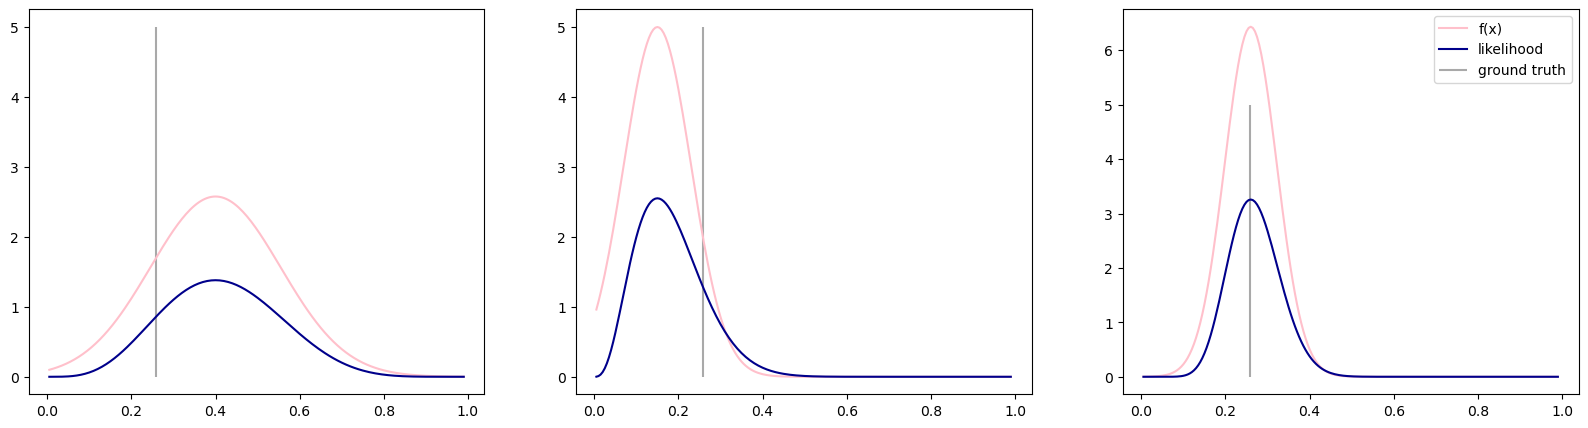

In [94]:
N = [10, 20, 50]
likelihood_scaling = 100

n_plots = 3

probs = np.arange(0.005, 0.995, 0.005)

fig, ax = plt.subplots(1, n_plots, figsize=(20, 5))

for i in range(n_plots):
        current_N = N[i]

        exit_poll_counts, _ = exit_poll(rng, poll_size=current_N, votes=votes_all, parties=parties_all)
        pi_hat, cov = compute_params(exit_poll_counts)
        ax[i].plot(probs, scipy.stats.norm.pdf(probs, pi_hat, np.sqrt(cov)), color='pink', label='f(x)')
        ax[i].plot(probs, calc_likelihood(exit_poll_counts, probs)*likelihood_scaling, color='darkblue', label='likelihood')    
        ax[i].vlines(truth, 0, 5, color='darkgrey', label='ground truth')

plt.legend()
plt.show();

## Uncertainty quantification via bootstrap estimation

While in the current setting, we can compute the Fisher information in closed form, often, this is not the case.
An alternative is the bootstrap estimator, which resamples a given data set repeatedly to quantify the variability of an estimator.
More precisely, we resample the conducted exit poll with replacement and recompute the estimator.


Instead of the bootstrap estimator, one can also use a parametric bootstrap. There, instead of resampling the data with replacement, we use the knowledge that $(N_1, ..., N_K) \sim p(N \mid \pi)$ follows a bi/multinomial distribution with parameter $\pi=(\pi_1, ..., \pi_K)$. Then, we can parametrise the bi/multinomial distribution with the MLE, sample from $p(N \mid \hat \pi)$ and recompute maximum likelihood estimates for each sample.


**Task:**
Implement the bootstrap estimator and the parametric bootstrap estimator for the MLE of $\pi$. Choose a poll size of, e.g., $|N|=1000$. Repeat the plot from above, but replace the Gaussian bell with a histogram of bootstrapped MLEs. Choose the number of bootstrap samples appropriately.

In [95]:
def compute_bootstrap(exit_poll_counts,N_bootstrap):
    N_sample = exit_poll_counts.sum()
    rng = np.random.default_rng()

    m_party_bootstrap = (rng.choice(N_sample, size=(N_sample, N_bootstrap))
                     <= exit_poll_counts[0]).sum(axis=0)
    f_party_bootstrap = m_party_bootstrap / N_sample
    return f_party_bootstrap


In [96]:
def compute_parametric_bootstrap(exit_poll_counts,N_bootstrap):
    N_sample = exit_poll_counts.sum()
    mle_1 = exit_poll_counts[0]/N_sample
    binomial = scipy.stats.binom(N_sample, mle_1)

    m_party_param_bootstrap = binomial.rvs(size=N_bootstrap)

    f_party_param_bootstrap = m_party_param_bootstrap / N_sample
    return f_party_param_bootstrap

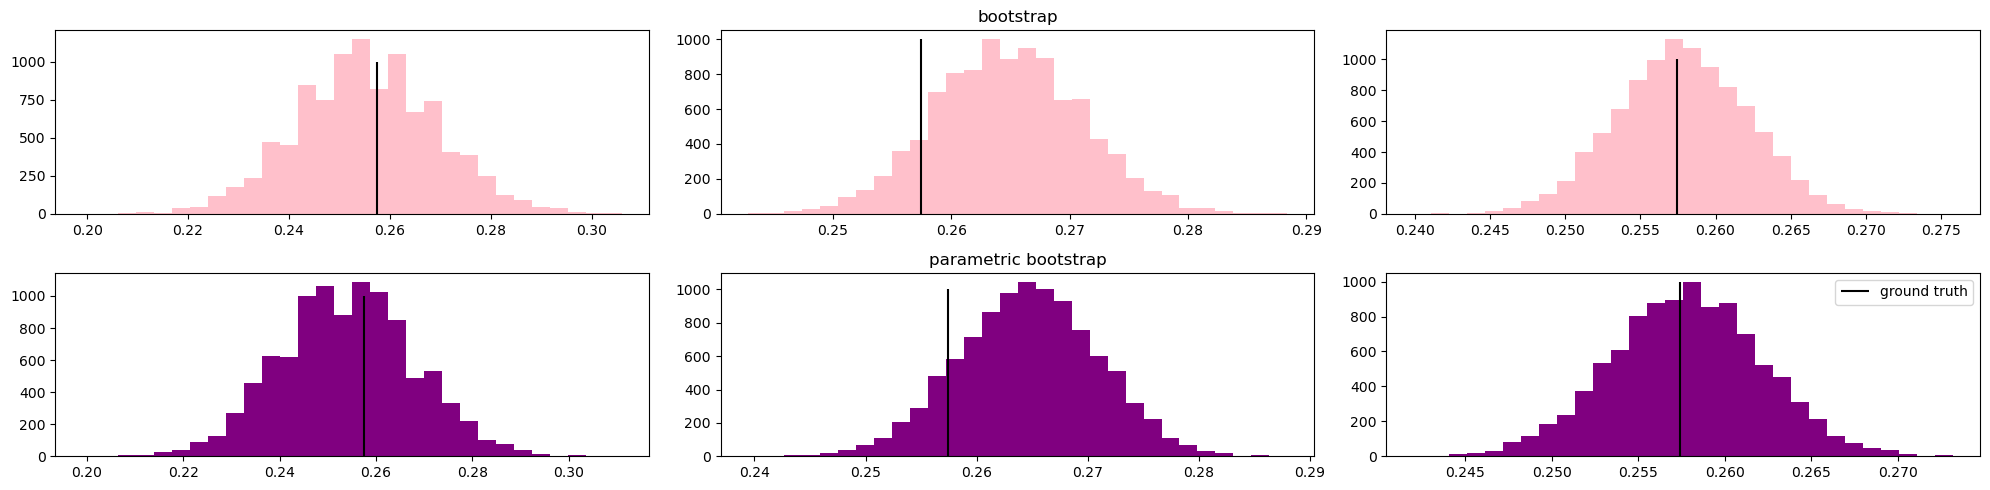

In [97]:
N = [1000, 5000, 10000]
N_bootstrap = 10000

n_x_plots = 3
n_y_plots = 2

fig, ax = plt.subplots(n_y_plots, n_x_plots, figsize=(20, 5))

for j in range(n_x_plots):
    current_N = N[j]

    exit_poll_counts, _ = exit_poll(rng, poll_size=current_N, votes=votes_all, parties=parties_all)
    f_bootstrap = compute_bootstrap(exit_poll_counts, N_bootstrap)
    f_param_bootstrap = compute_parametric_bootstrap(exit_poll_counts, N_bootstrap)
    
    ax[0,j].hist(f_bootstrap, bins=30, color='pink')
    ax[0,1].set_title('bootstrap')
    ax[1,j].hist(f_param_bootstrap, bins=30, color='purple')  
    ax[1,1].set_title('parametric bootstrap')
    ax[0,j].vlines(truth, 0, 1000, color='black', label='ground truth')
    ax[1,j].vlines(truth, 0, 1000, color='black', label='ground truth')
plt.legend()
plt.tight_layout()
plt.show()

We can use the bootstrap estimator on a wide range of estimates. For example, we can quantify the uncertainty over estimating $P(\{\text{My Party}\} > \text{threshold})$.
For given exit poll $N=(N_1, ..., N_K)$, last week, we saw how to compute the probability of a party receiving more than a certain share of votes. Using the bootstrap (or parametric bootstrap), we can resample the data and recompute this probability for each sample.

**Task:**
Implement this resampling, and plot 50 bootstrap samples each of which describes the probability of SPD exceeding 0.22% of votes, for increasing exit poll counts $|N|$. How large does the poll have to be for us to be confident about SPD exceeding 0.22% of votes?

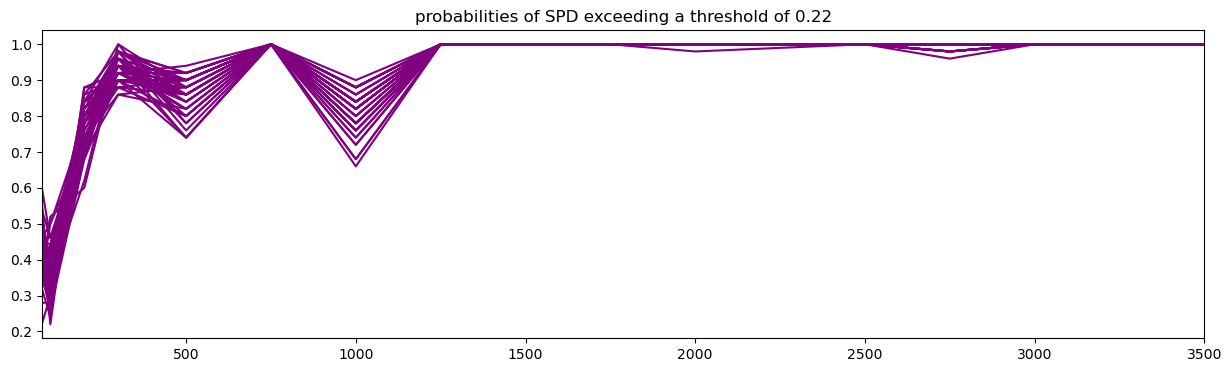

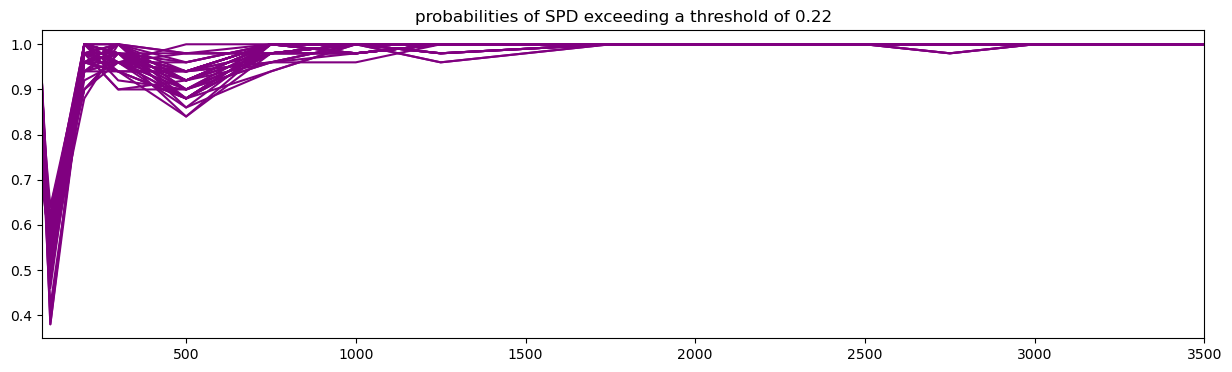

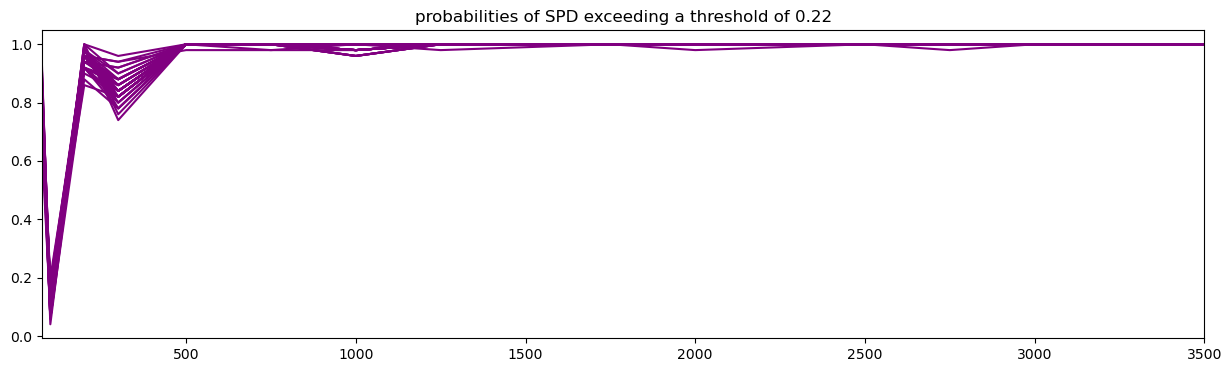

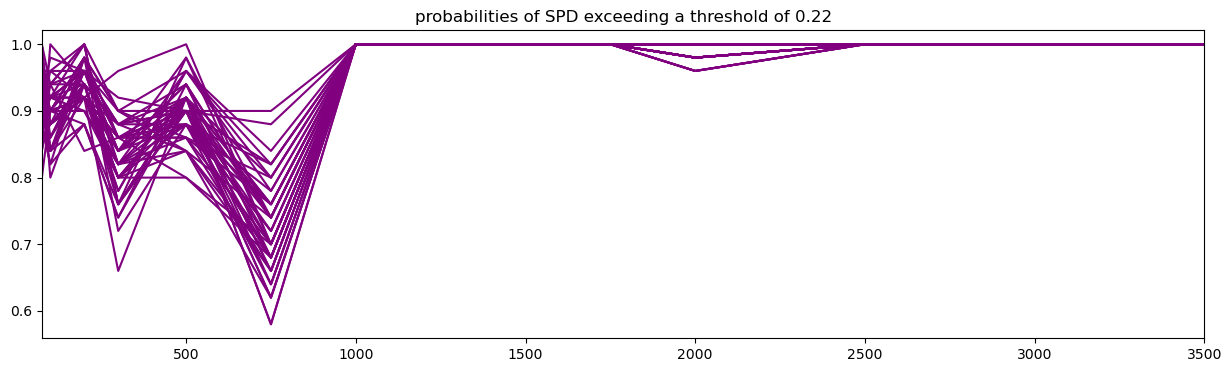

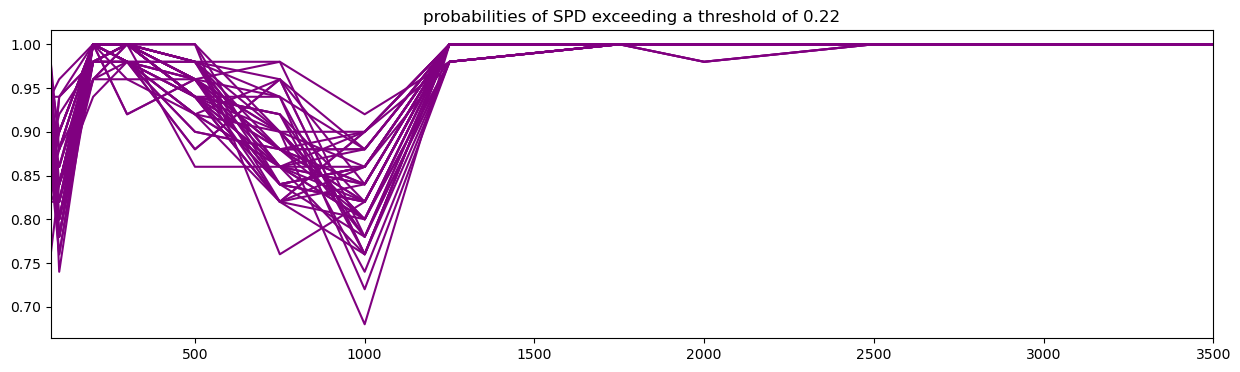

In [101]:
for i in range(0,5):
    N = [75, 100, 200, 300, 500, 750, 1000, 1250, 1750, 2000, 2500, 2750, 3000, 3250, 3500]
    threshold = 0.22
    bootstrap_samples = 50
    probs_all = []
    std_probs_bs = []
    se_all = []
    for n in N:
        exit_poll_counts, poll = exit_poll(np.random.default_rng(),poll_size=n, votes=votes_all, parties=parties_all)
        probs_bs = []
        for j in range(0,50):
            param_bootstrap = compute_parametric_bootstrap(exit_poll_counts,bootstrap_samples)
            probs = (param_bootstrap >= threshold).sum()/bootstrap_samples
            probs_bs.append(probs)
        se_all.append(scipy.stats.sem(probs_bs))
        std_probs_bs.append(np.std(probs_bs))
        probs_all.append(probs_bs)

    plt.figure(figsize=(15, 4))
    plt.plot(N, probs_all, color='purple')
    plt.xlim(N[0], N[-1])
    plt.title('probabilities of SPD exceeding a threshold of 0.22')
    plt.show();

After comparing multiple outputs for 50 bootstrape samples and various poll sizes, we come to the conclusion that with a poll size of 3000, we can be confident about the SPD exceeding 22% of the votes.

Instead of the samples, we can also measure the evolution of the standard deviation of the samples for increasing exit poll size.

**Task:**
Plot the standard deviation of the bootstrap samples from above against the exit poll size. Compare this to the error.

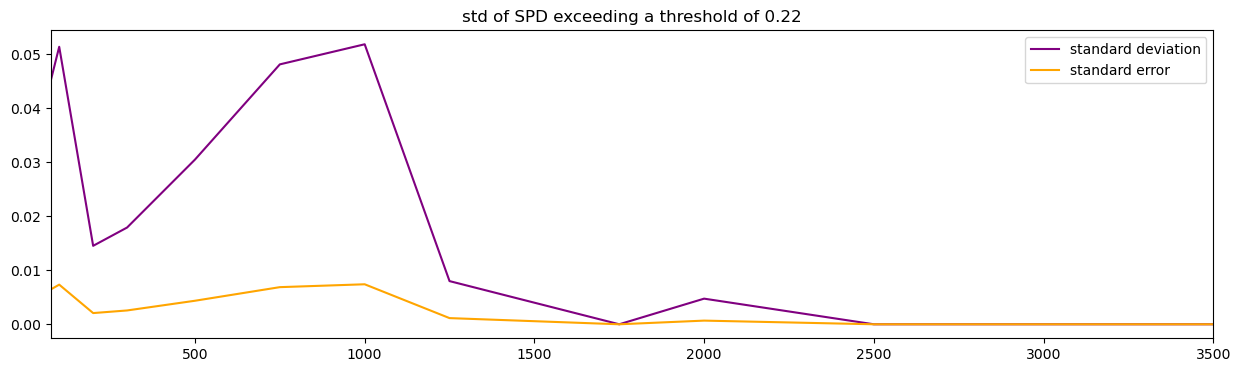

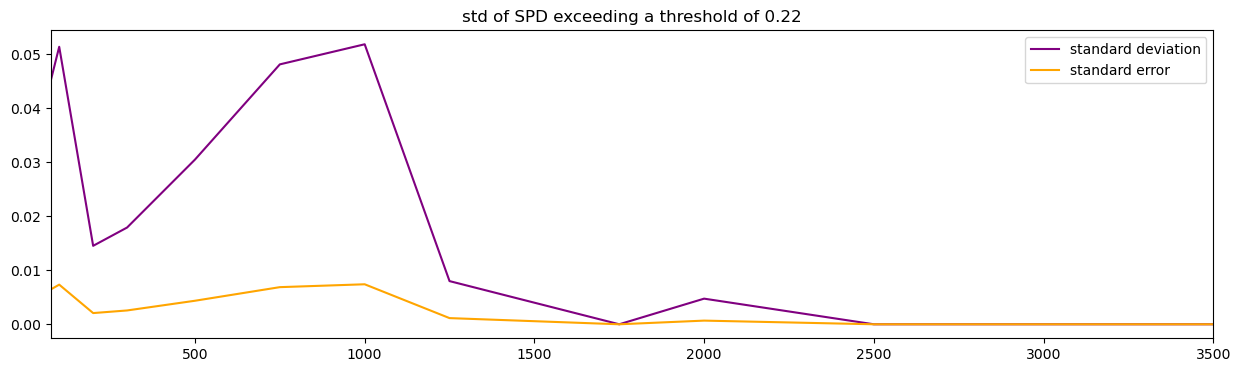

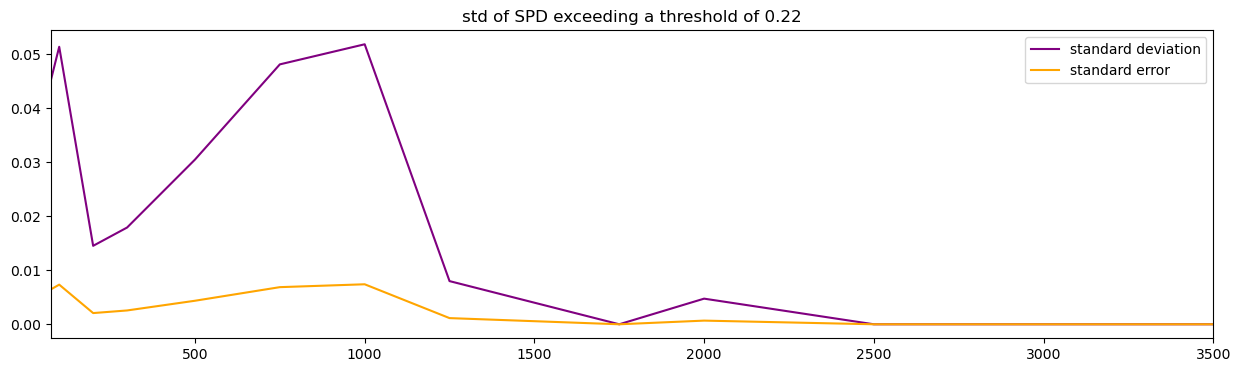

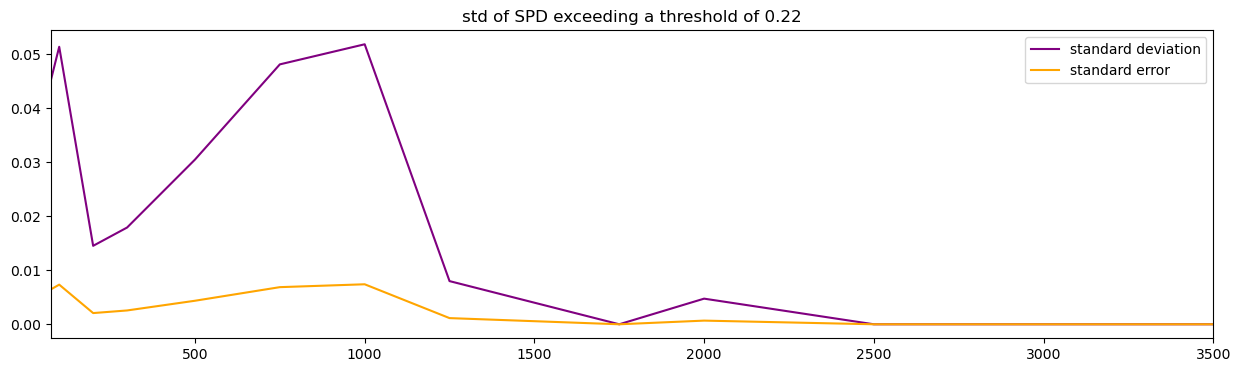

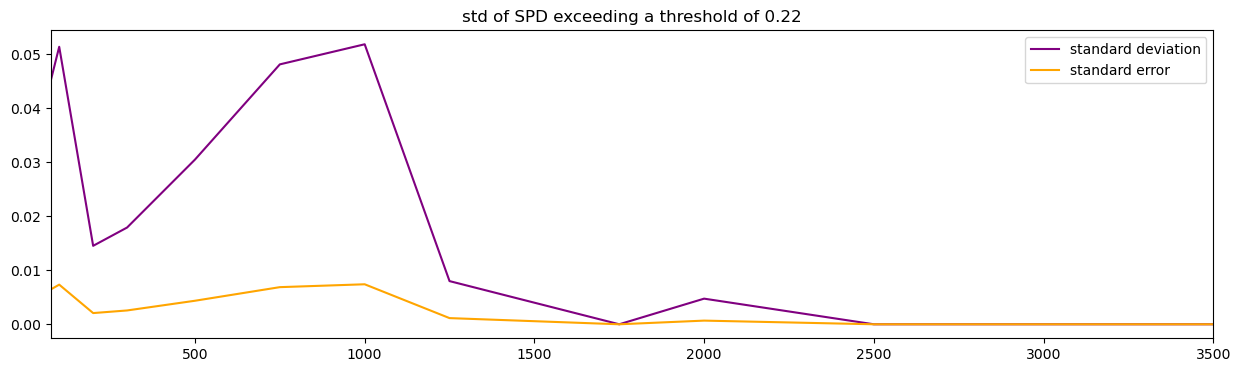

In [104]:
for i in range(0,5):
    N = [75, 100, 200, 300, 500, 750, 1000, 1250, 1750, 2000, 2500, 2750, 3000, 3250, 3500]
    plt.figure(figsize=(15, 4))
    plt.plot(N, std_probs_bs, color='purple', label = 'standard deviation')
    plt.plot(N, se_all, color='orange', label = 'standard error')
    plt.xlim(N[0], N[-1])
    plt.legend(loc='upper right')
    plt.title('std of SPD exceeding a threshold of 0.22')
    plt.show();

We can see that with increasing poll size, the standard deviation as well as the standard error decrease.